In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

from utils import *
from autoencoder import *

In [17]:
'''
When taking inputs first check sanity and warn user.
ex: check file paths and output path (if output exists give warning before overwrite)
'''

'\nWhen taking inputs first check sanity and warn user.\n'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device name:', torch.cuda.get_device_name(), '\n')

Device name: NVIDIA A100-SXM4-80GB 



In [3]:
traj_dl, n_atoms = read_traj_to_dl(
    traj_ = '/orange/alberto.perezant/t.desilva/insulin/water/no_water_aligned/md_water.nc', 
    top_ = '/orange/alberto.perezant/t.desilva/insulin/water/no_water_aligned/system.parm7',
    batch_size = 128,
    stride = 100,
    memmap=False
)


Trajectory stats : #_Frames = 100000	#_Atoms = 202
______________________________________________________________________ 

Start reading coordinates from trajectory to train model...
[1000 frames with stride 100]


Loading trajectory: 100.00% |████████████████████|


DataLoader created
______________________________________________________________________ 



In [4]:
model = AE(n_atoms=n_atoms)
model = LightAE(model=model, lr=1e-4, weight_decay=0)

In [5]:
torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(max_epochs=100, accelerator='gpu', devices=1)
print('Training Autoencoder:')
trainer.fit(model, traj_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/blue/alberto.perezant/t.desilva/conda/envs/compress/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/alberto.perezant/t.desilva/Compress/compress/lightning_logs/version_54847558/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | AE       | 28.2 M | train
1 | loss_fn | RMSELoss | 0      | train
---------------------------------------------
28.2 M    Trainable params
0         Non-trainable params
28.2 M    Total params
112.708   Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.
/blue/alberto.perezant/t.desilva/conda/envs/compress/lib/python3.12/site-packages/pytorch_lightning/loop

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Autoencoder training complete

______________________________________________________________________ 




alculating RMSD : 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

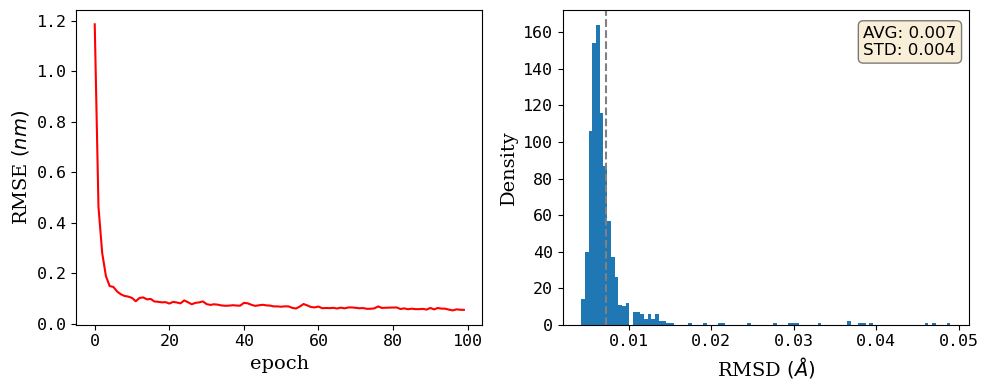

In [7]:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)

ax[0].tick_params(axis='both', which='major', labelsize=12, labelfontfamily='monospace')
ax[0].plot(model.epoch_losses, color='red')
ax[0].set_xlabel('epoch', fontsize=14, fontfamily='serif')
ax[0].set_ylabel('RMSE $(nm)$', fontsize=14, fontfamily='serif')

ax[1].tick_params(axis='both', which='major', labelsize=12, labelfontfamily='monospace')
x = rmsd_validation(model=model, dl=traj_dl, 
                    top = '/orange/alberto.perezant/t.desilva/insulin/water/no_water_aligned/system.parm7')*10
ax[1].hist(x, bins=100)
ax[1].set_xlabel(r'RMSD $(\AA)$', fontsize=14, fontfamily='serif')
ax[1].set_ylabel('Density', fontsize=14, fontfamily='serif')
ax[1].text(0.74, 0.95, f'AVG: {np.mean(x):.3f}\nSTD: {np.std(x):.3f}', transform=ax[1].transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax[1].axvline(x=np.mean(x), color='grey', linestyle='--', label='Vertical line at x=7')
#give average value and the standard deviation

plt.tight_layout()
plt.show()

In [8]:
# are there ways to get correlation coefficient for 3d data? -- get it to validate model

In [20]:
print('Saving model parmeters')
torch.save(model, 'model.pt')

Saving model parmeters
